# A Comparative Study on Home Loan Approval Classification Dataset Using XGBoost, Light Gradient Boosting Machine (LGBM), SVM Classifier, Logistic Regression, and Deep Neural Network
<hr>
Kevin Putra Santoso, Department of Information Technology

Sepuluh Nopember Institute of Technology

## Import Libraries

In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Reading Data and Preprocessing

In [310]:
df_train = pd.read_csv('/kaggle/input/home-loan-approval/loan_sanction_train.csv')
df_train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## Check null values

In [311]:
pd.DataFrame(df_train.isnull().sum(), columns=['count'])

,count
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


I'm going to drop Loan_ID since its unique, so that it can prevent overfitting.

In [312]:
df_train = df_train.drop(columns='Loan_ID')

Let's check for categorical and numerical columns in the dataset

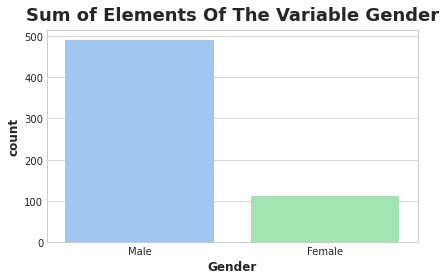

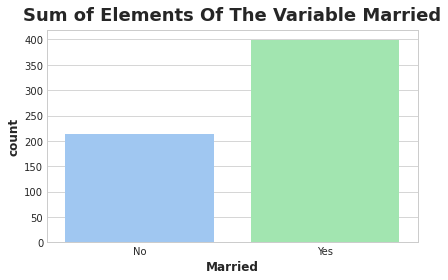

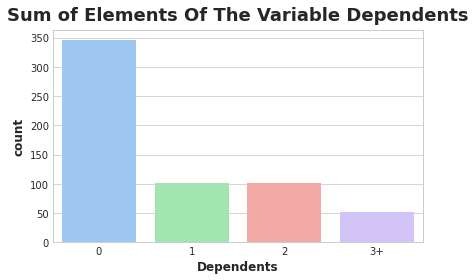

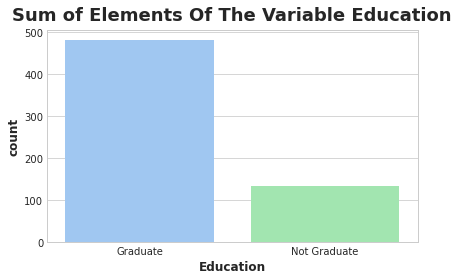

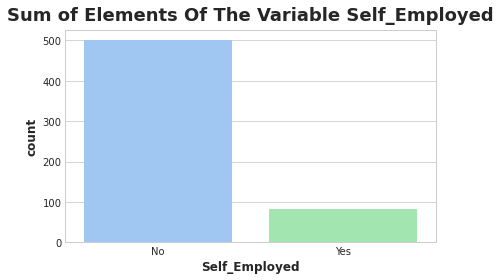

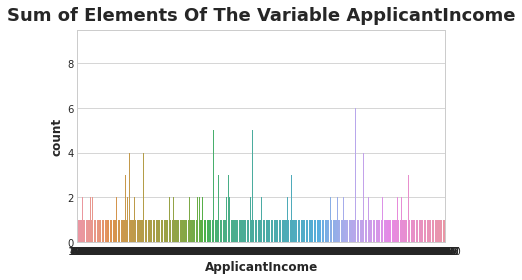

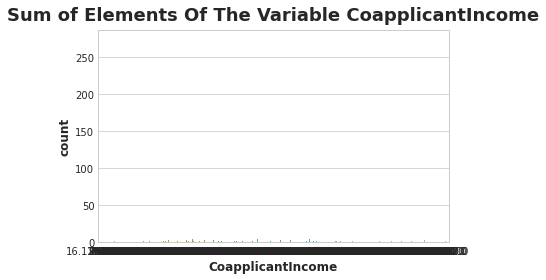

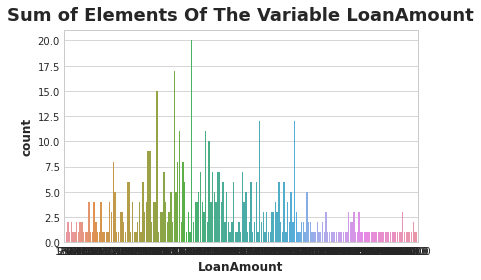

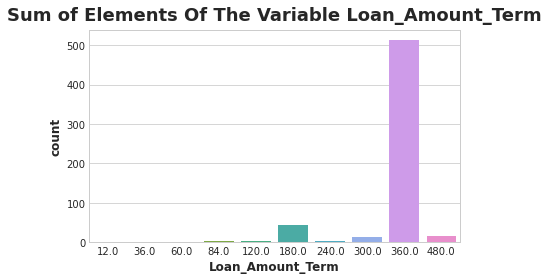

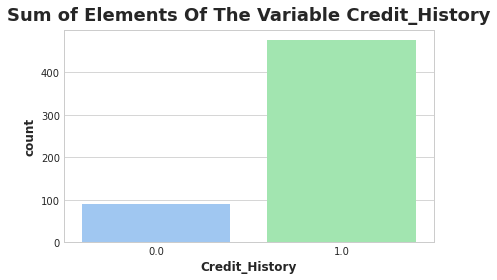

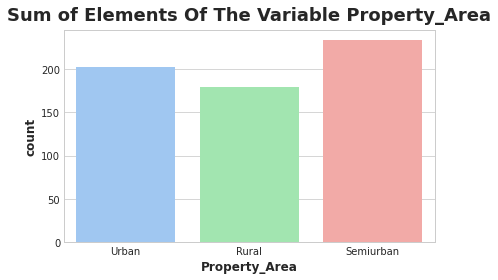

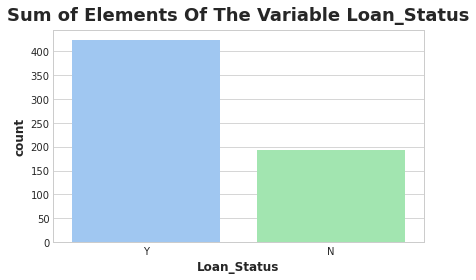

In [313]:
for i in df_train.columns:
    plt.title(f"Sum of Elements Of The Variable {i}")
    sns.countplot(df_train[i])
    plt.show()

Based on the visualization above, now we can determine which columns are categorical and which columns are numerical.

In [314]:
categoricalFeatures = ['Gender', 'Married', 'Dependents',
                       'Education', 'Self_Employed', 'Loan_Amount_Term',
                       'Credit_History', 'Property_Area', 'Loan_Status']
numericalFeatures = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

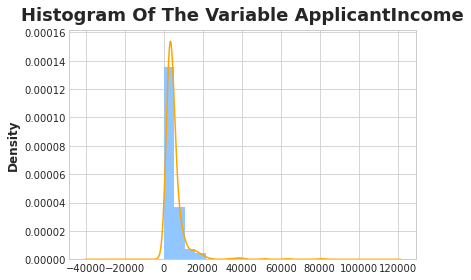

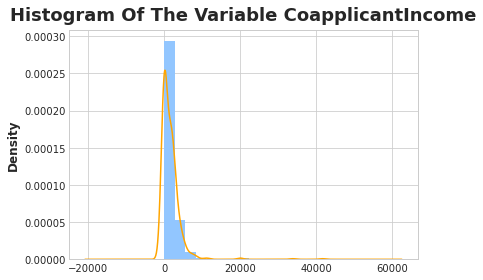

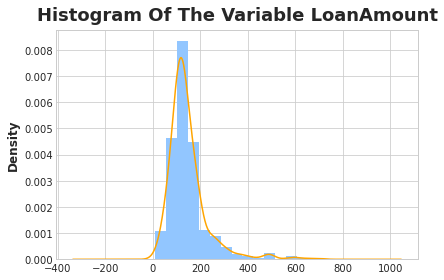

In [315]:
for i in df_train[numericalFeatures]:
    plt.title(f"Histogram Of The Variable {i}")
    df_train[i].plot(kind = "hist", density = True, bins = 15)
    df_train[i].plot(kind = "kde", color='orange')
    plt.show()

Since there are many null values, rather than drop the data, let's impute them instead. Here I'm going to use simple KNN Imputer after I standardized my numerical columns and apply label encoding to my categorical columns.

In [316]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def LabelEncoding(X):
    le = LabelEncoder()
    for i in categoricalFeatures:
        X[i] = le.fit_transform(X[i])
    return X

df_train = LabelEncoding(df_train)

In [317]:
df_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,NaN,8,1,2,1
1,1,1,1,0,0,4583,1508.0,128.0,8,1,0,0
2,1,1,0,0,1,3000,0.0,66.0,8,1,2,1
3,1,1,0,1,0,2583,2358.0,120.0,8,1,2,1
4,1,0,0,0,0,6000,0.0,141.0,8,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,2900,0.0,71.0,8,1,0,1
610,1,1,3,0,0,4106,0.0,40.0,5,1,0,1
611,1,1,1,0,0,8072,240.0,253.0,8,1,2,1
612,1,1,2,0,0,7583,0.0,187.0,8,1,2,1


In [318]:
from sklearn.impute import KNNImputer

df_knn = df_train.filter(numericalFeatures, axis=1).copy()
df_knn

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,5849,0.0,NaN
1,4583,1508.0,128.0
2,3000,0.0,66.0
3,2583,2358.0,120.0
4,6000,0.0,141.0
...,...,...,...
609,2900,0.0,71.0
610,4106,0.0,40.0
611,8072,240.0,253.0
612,7583,0.0,187.0


In [319]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns=df_knn.columns)

knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

In [320]:
df_knn_imputed

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,0.072991,-0.554487,0.016229
1,-0.134412,-0.038732,-0.215309
2,-0.393747,-0.554487,-0.940328
3,-0.462062,0.251980,-0.308860
4,0.097728,-0.554487,-0.063289
...,...,...,...
609,-0.410130,-0.554487,-0.881859
610,-0.212557,-0.554487,-1.244368
611,0.437174,-0.472404,1.246423
612,0.357064,-0.554487,0.474628


In [321]:
df_train[numericalFeatures] = df_knn_imputed
df_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,0.072991,-0.554487,0.016229,8,1,2,1
1,1,1,1,0,0,-0.134412,-0.038732,-0.215309,8,1,0,0
2,1,1,0,0,1,-0.393747,-0.554487,-0.940328,8,1,2,1
3,1,1,0,1,0,-0.462062,0.251980,-0.308860,8,1,2,1
4,1,0,0,0,0,0.097728,-0.554487,-0.063289,8,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,-0.410130,-0.554487,-0.881859,8,1,0,1
610,1,1,3,0,0,-0.212557,-0.554487,-1.244368,5,1,0,1
611,1,1,1,0,0,0.437174,-0.472404,1.246423,8,1,2,1
612,1,1,2,0,0,0.357064,-0.554487,0.474628,8,1,2,1


Text(0.5, 1.04, 'Pairplot of Dataset Based On Property Area')

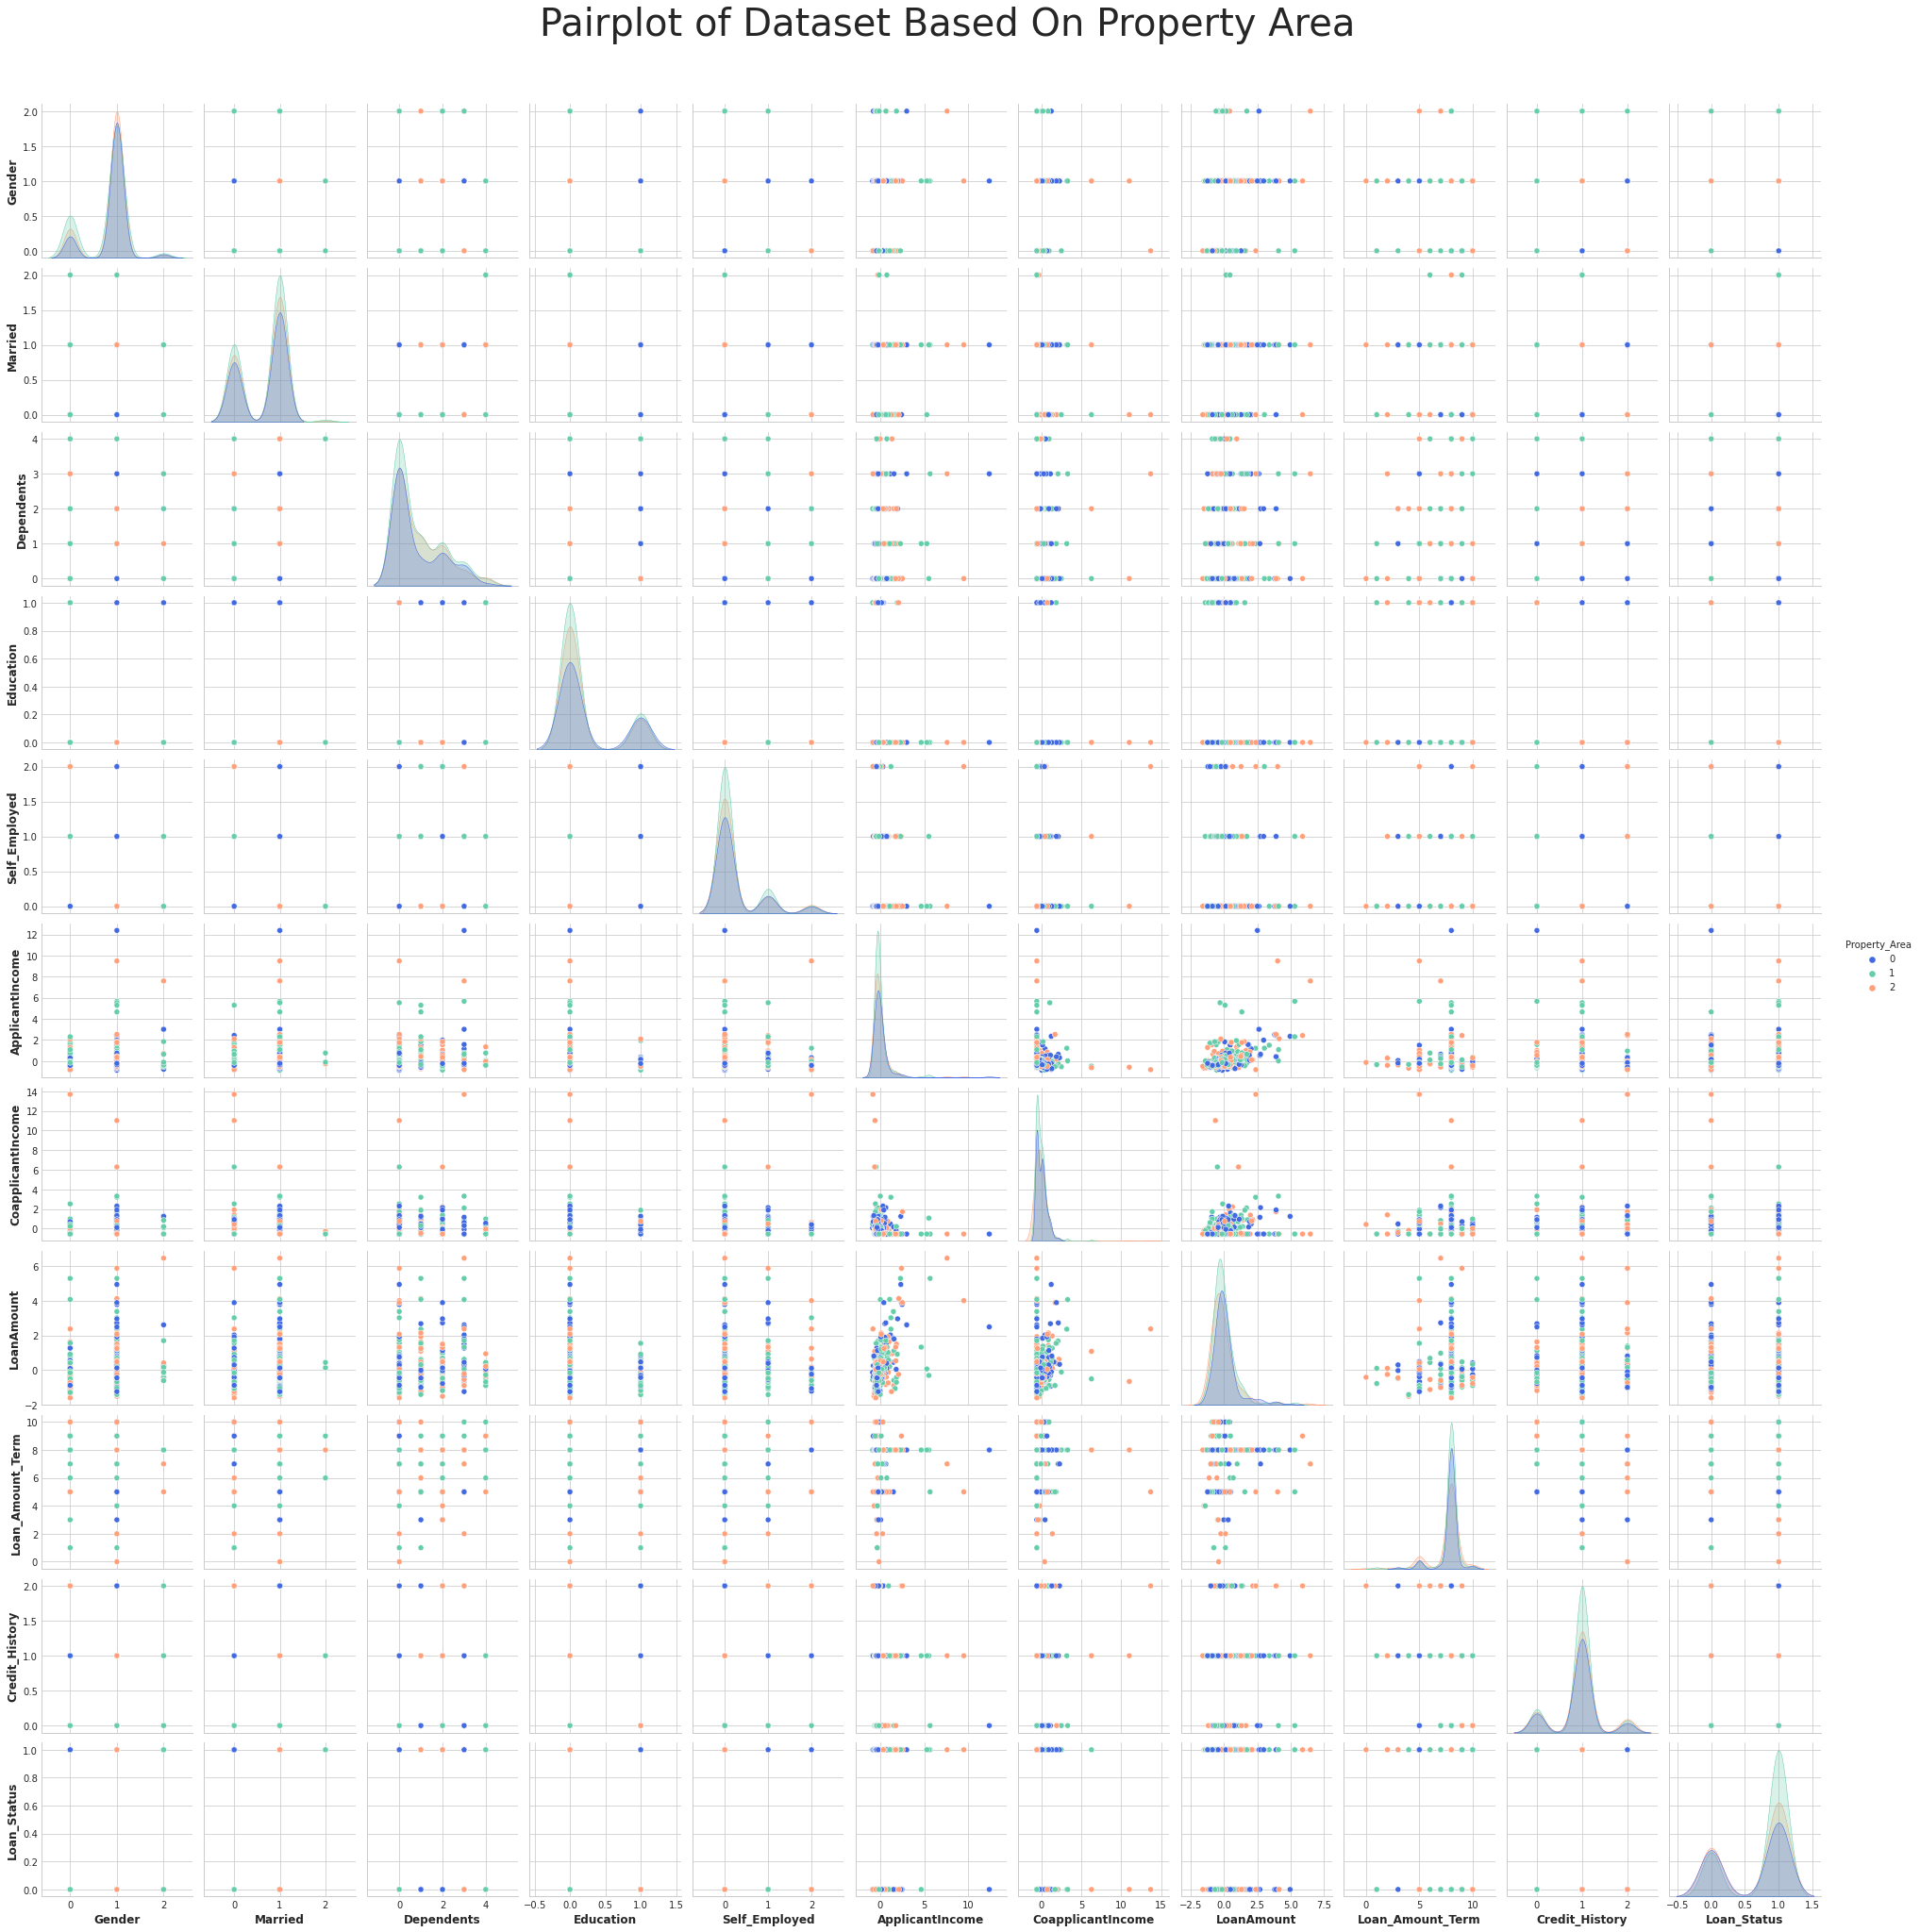

In [322]:
sns.pairplot(df_train, hue="Property_Area", palette=['#4169E1', '#66CDAA','#FFA07A']).fig.suptitle("Pairplot of Dataset Based On Property Area", y=1.04, fontsize=40)

## Feature Correlation Analysis

Let's analyze the features using pearson correlation. I will drop the dependent features that having low correlation with the target column.

<AxesSubplot:>

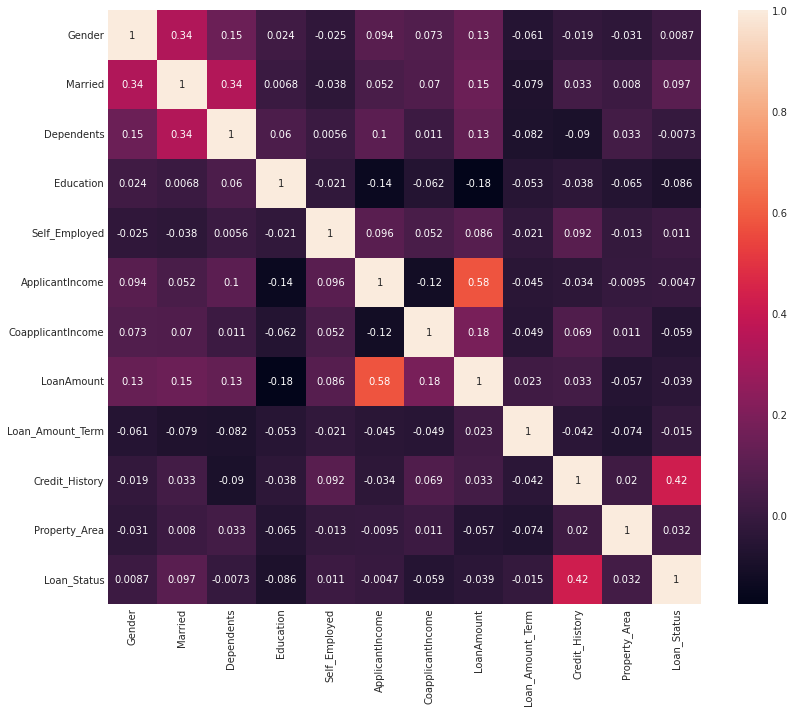

In [323]:
plt.figure(figsize=(12,10))
sns.heatmap(df_train.corr(), annot=True)

From this correlation matrix, we can see that there are several variables that depends on other variables. Let's drop ApplicantIncome, Dependents, and Gender since they have a lower Pearson correlation value with the target compared to their pair.

In [324]:
df_train = df_train.drop(columns=['ApplicantIncome', 'Dependents', 'Gender'])

<AxesSubplot:>

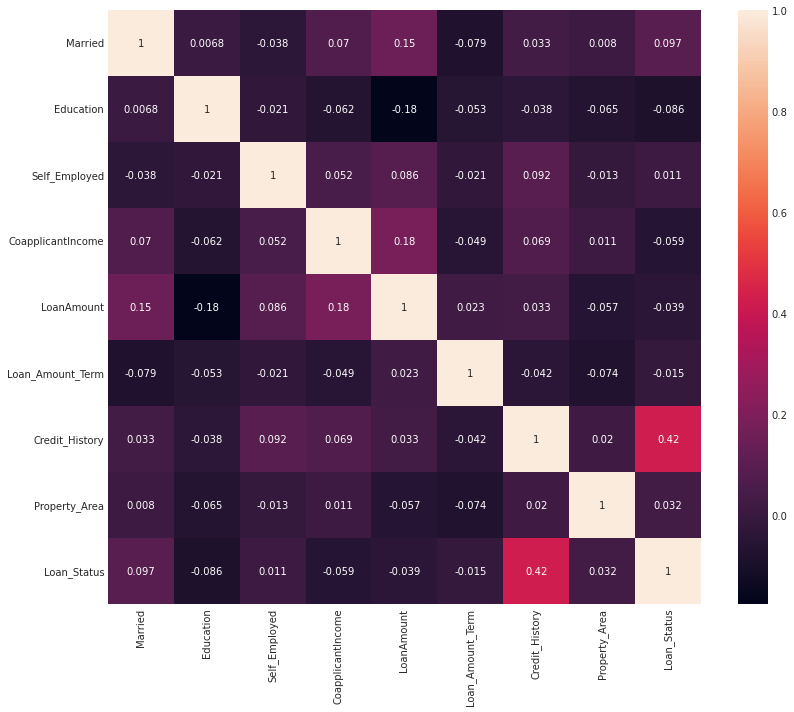

In [325]:
plt.figure(figsize=(12,10))
sns.heatmap(df_train.corr(), annot=True)

After that, split the data with ratio 8:2

In [326]:
from sklearn.model_selection import train_test_split

X = df_train.drop(columns='Loan_Status')
y = df_train['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.2, 
                                                  random_state=142)

In [327]:
!pip install xgboost

## Applying and Compare Models

**A. Using XGBoost Classifier**

In [328]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

model_xgb = XGBClassifier(tree_method='gpu_hist',
                          max_depth=20,
                          learning_rate=0.1,
                          subsample=0.3,
                          colsample_bytree=0.7,
                          colsample_bylevel=0.4,
                          n_estimators=100                               
                          )
model_xgb.fit(X_train, y_train, eval_set=[(X_val,y_val)])

[0]	validation_0-logloss:0.68092
[1]	validation_0-logloss:0.65576
[2]	validation_0-logloss:0.64208
[3]	validation_0-logloss:0.62261
[4]	validation_0-logloss:0.60086
[5]	validation_0-logloss:0.59583
[6]	validation_0-logloss:0.59413
[7]	validation_0-logloss:0.57695
[8]	validation_0-logloss:0.56746
[9]	validation_0-logloss:0.55558
[10]	validation_0-logloss:0.55015
[11]	validation_0-logloss:0.54329
[12]	validation_0-logloss:0.53155
[13]	validation_0-logloss:0.53193
[14]	validation_0-logloss:0.53400
[15]	validation_0-logloss:0.52724
[16]	validation_0-logloss:0.51884
[17]	validation_0-logloss:0.51549
[18]	validation_0-logloss:0.50847
[19]	validation_0-logloss:0.51110
[20]	validation_0-logloss:0.50637
[21]	validation_0-logloss:0.50224
[22]	validation_0-logloss:0.50215
[23]	validation_0-logloss:0.50272
[24]	validation_0-logloss:0.50636
[25]	validation_0-logloss:0.50366
[26]	validation_0-logloss:0.50240
[27]	validation_0-logloss:0.50092
[28]	validation_0-logloss:0.49993
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.4, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

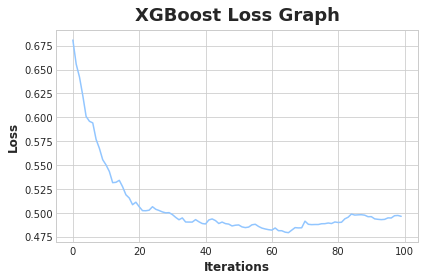

In [329]:
results = model_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'])
plt.title('XGBoost Loss Graph')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

              precision    recall  f1-score   support

           0     0.7391    0.4722    0.5763        36
           1     0.8100    0.9310    0.8663        87

    accuracy                         0.7967       123
   macro avg     0.7746    0.7016    0.7213       123
weighted avg     0.7893    0.7967    0.7814       123

Total false count: 25 
Accuracy: 79.67%


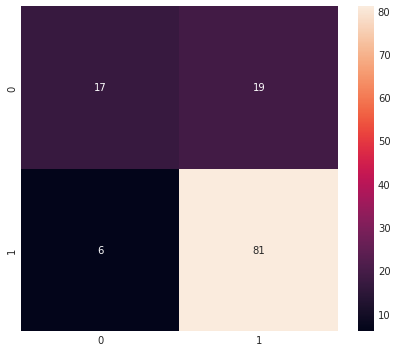

In [330]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_xgb = model_xgb.predict(X_val)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val.values,y_pred_xgb), annot=True, fmt=".0f")
print(classification_report(y_val.values,y_pred_xgb, digits=4))
false=[]
  
for i in range(len(y_val.values)):
      if y_val.values[i]!=y_pred_xgb[i]:
          false.append(i)
          
print("Total false count: %d "%len(false))  
print("Accuracy: %0.2f%%"%(accuracy_score(y_val.values, y_pred_xgb)*100))

**B. Using BoostARootA Feature Selector for XGBoost**

In [331]:
!pip install boostaroota

In [332]:
from boostaroota import BoostARoota

print("==== Feature Selection ====")
br = BoostARoota(clf=model_xgb, iters=10)
br.fit(X,y)
features = list(br.keep_vars_)
print("Selected Features:")
print(features)
print("Total features: %d"%len(features))

==== Feature Selection ====
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
BoostARoota ran successfully! Algorithm went through  1  rounds.
Selected Features:
['Married', 'Education', 'Self_Employed', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
Total features: 8


I'm going to build different models from each data. One without boostaroota features and one for boostaroota features included.

In [333]:
X_train_fs = X_train[features]
X_val_fs = X_val[features]

In [334]:
model_xgb.fit(X_train_fs, y_train)
y_pred_xgb_bsta = model_xgb.predict(X_val_fs)

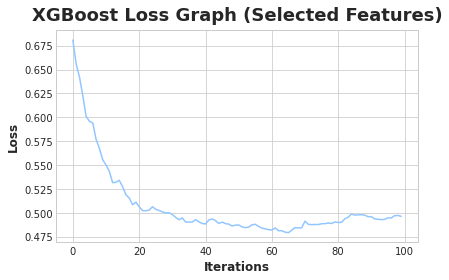

In [335]:
results = model_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('XGBoost Loss Graph (Selected Features)')
plt.show()

              precision    recall  f1-score   support

           0     0.7391    0.4722    0.5763        36
           1     0.8100    0.9310    0.8663        87

    accuracy                         0.7967       123
   macro avg     0.7746    0.7016    0.7213       123
weighted avg     0.7893    0.7967    0.7814       123

Total false count: 25 
Accuracy: 79.67%


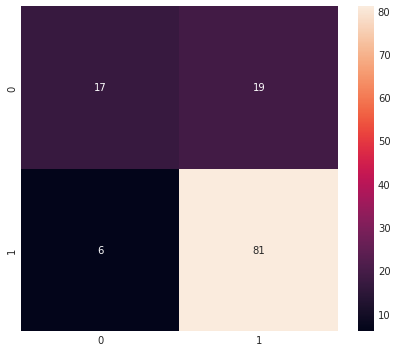

In [336]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val.values,y_pred_xgb_bsta), annot=True, fmt=".0f")
print(classification_report(y_val.values,y_pred_xgb_bsta, digits=4))
false=[]
  
for i in range(len(y_val.values)):
      if y_val.values[i]!=y_pred_xgb_bsta[i]:
          false.append(i)
          
print("Total false count: %d "%len(false))  
print("Accuracy: %0.2f%%"%(accuracy_score(y_val.values, y_pred_xgb_bsta)*100))

Looks like there's no much differences, or no differences at all :/

**C. Using SVM Classifier**

In [337]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=1,random_state=142).fit(X_train, y_train)
clf_fs = SVC(kernel='rbf', C=1,random_state=142).fit(X_train_fs, y_train)
print("SVM Score: %0.2f%%" %(clf.score(X_val, y_val)*100))
print("SVM Score (Feature Selected): %0.2f%%" %(clf_fs.score(X_val_fs, y_val)*100))

SVM Score: 82.11%
SVM Score (Feature Selected): 82.11%


**D. Using Logistic Regression**

In [338]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(C=3.5, solver='newton-cg').fit(X_train, y_train)
reg_fs = LogisticRegression(C=3.5, solver='newton-cg').fit(X_train_fs, y_train)
print("Logistic Regression Acc Score: %0.2f%%" %(reg.score(X_val, y_val) * 100))
print("Logistic Regression Acc Score (Feature Selected): %0.2f%%" %(reg.score(X_val_fs, y_val)*100))

Logistic Regression Acc Score: 82.11%
Logistic Regression Acc Score (Feature Selected): 82.11%


**E. Using Light Gradient Boosting**

In [339]:
!pip install verstack

In [340]:
!pip install --upgrade verstack


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: f1 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.4128119093386432
     .. Evaluation score (greater-better): f1: 0.888888888888889
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.4675540623544006
     .. Evaluation score (greater-better): f1: 0.888888888888889
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.44960177773262755
     .. Evaluation score (greater-better): f1: 0.858695652173913
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.4694577964974029
     .. Ev

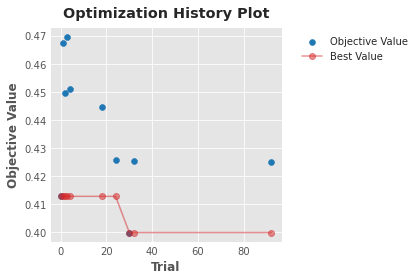

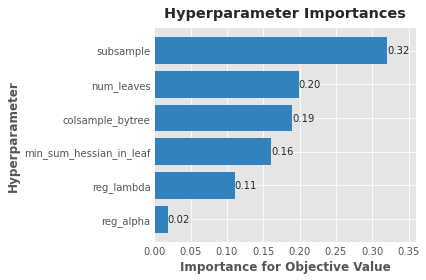

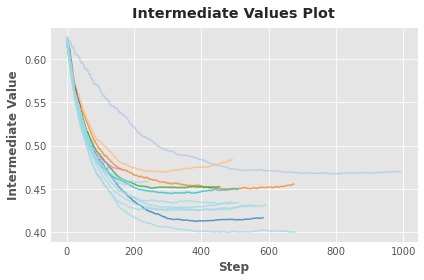

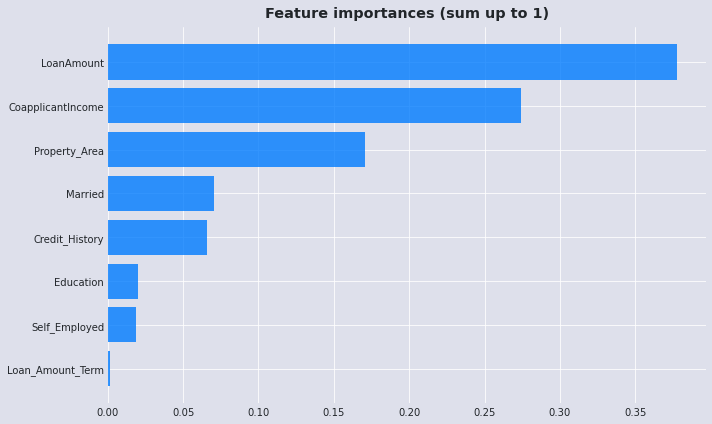


     . Optuna hyperparameters optimization finished
     .. Best trial number:30    |     log_loss:          0.39993135637595456
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:   52   |     f1:           0.8601036269430051

Time elapsed for fit execution: 17.2892 seconds


In [341]:
from verstack import LGBMTuner

tuner = LGBMTuner(metric = 'f1')
tuner.fit(X_train_fs, y_train)
y_pred_lgbm = tuner.predict(X_val_fs)

              precision    recall  f1-score   support

           0     1.0000    0.3611    0.5306        36
           1     0.7909    1.0000    0.8832        87

    accuracy                         0.8130       123
   macro avg     0.8955    0.6806    0.7069       123
weighted avg     0.8521    0.8130    0.7800       123

Total false count: 23 
Accuracy: 81.30%


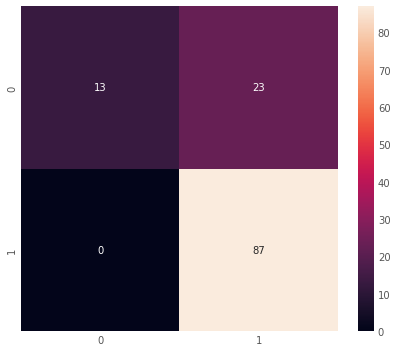

In [342]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val.values,y_pred_lgbm), annot=True, fmt=".0f")
print(classification_report(y_val.values,y_pred_lgbm, digits=4))
false=[]
  
for i in range(len(y_val.values)):
      if y_val.values[i]!=y_pred_lgbm[i]:
          false.append(i)
          
print("Total false count: %d "%len(false))  
print("Accuracy: %0.2f%%"%(accuracy_score(y_val.values, y_pred_lgbm)*100))

**E. Using Deep Neural Network**

In [343]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

model = keras.Sequential([
    layers.Dense(32, activation='tanh', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.3),
    layers.Dense(16, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

bce = BinaryCrossentropy()
model.compile(
    loss=bce,
    optimizer='adam',
    metrics=[bce] 
)

cp = ModelCheckpoint('model/', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[cp]
)

Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 0.7106 - binary_crossentropy: 0.7125 - val_loss: 0.5967 - val_binary_crossentropy: 0.5967
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6695 - binary_crossentropy: 0.6657 - val_loss: 0.6148 - val_binary_crossentropy: 0.6148
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7105 - binary_crossentropy: 0.7120 - val_loss: 0.6191 - val_binary_crossentropy: 0.6192
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6874 - binary_crossentropy: 0.6862 - val_loss: 0.6062 - val_binary_crossentropy: 0.6062
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6582 - binary_crossentropy: 0.6583 - val_loss: 0.5988 - val_binary_crossentropy: 0.5989
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6660 - binary_crossentropy: 0.6682 - val_loss: 0.5969 - val_binary_crossentropy: 0.5969
Epoch 7/100
8/8 [================

Text(0.5, 1.0, 'Loss Function Graph')

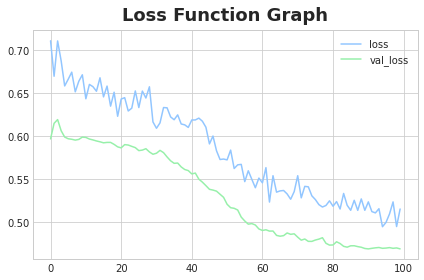

In [344]:
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot().set_title('Loss Function Graph', fontsize=18)

In [345]:
y_pred_dnn = model.predict(X_val)
y_pred_dnn = pd.DataFrame(y_pred_dnn)
y_val_dnn = pd.DataFrame(y_val).reset_index(drop=True)

for i in range(len(y_pred_dnn)):
  if (y_pred_dnn.iloc[i][0] > 0.5):
    y_pred_dnn.iloc[i][0] = 1
  else:
    y_pred_dnn.iloc[i][0] = 0

              precision    recall  f1-score   support

           0     0.9375    0.4167    0.5769        36
           1     0.8037    0.9885    0.8866        87

    accuracy                         0.8211       123
   macro avg     0.8706    0.7026    0.7318       123
weighted avg     0.8429    0.8211    0.7960       123

Total false count: 22 
Accuracy: 82.11%


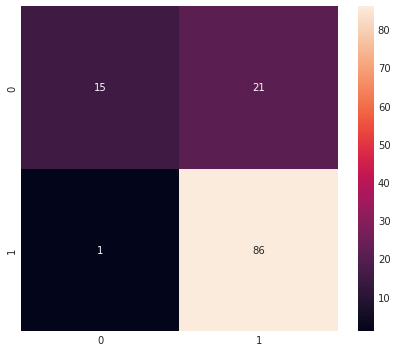

In [346]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val_dnn.values,y_pred_dnn), annot=True, fmt=".0f")
print(classification_report(y_val_dnn.values,y_pred_dnn, digits=4))
false=[]
  
for i in range(len(y_val_dnn.values)):
      if y_val_dnn.values[i]!=y_pred_dnn.iloc[i][0]:
          false.append(i)
          
print("Total false count: %d "%len(false))  
print("Accuracy: %0.2f%%"%(accuracy_score(y_val_dnn.values, y_pred_dnn) * 100))

Based on the LGBM Tuner result, Loan_Amount_Term and Self_Employed have a low rank on feature importances. Therefore, I will try to drop it and see if it gives some effects.

In [347]:
X_train_noLAT = X_train[['Married', 'Education', 'CoapplicantIncome', 
                         'LoanAmount', 'Credit_History', 'Property_Area']]
X_val_noLAT = X_val[['Married', 'Education', 'CoapplicantIncome', 
                     'LoanAmount', 'Credit_History', 'Property_Area']]

In [348]:
model2 = keras.Sequential([
    layers.Dense(32, activation='tanh', input_shape=[X_train_noLAT.shape[1]]),
    layers.Dropout(0.3),
    layers.Dense(16, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(
    loss=bce,
    optimizer='adam',
    metrics=[bce] 
)

cp = ModelCheckpoint('model2/', save_best_only=True)

history = model2.fit(
    X_train_noLAT, y_train,
    validation_data=(X_val_noLAT, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[cp]
)

Epoch 1/100
8/8 [==============================] - 1s 36ms/step - loss: 0.7369 - binary_crossentropy: 0.7359 - val_loss: 0.6169 - val_binary_crossentropy: 0.6172
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6416 - binary_crossentropy: 0.6421 - val_loss: 0.5702 - val_binary_crossentropy: 0.5705
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6380 - binary_crossentropy: 0.6373 - val_loss: 0.5601 - val_binary_crossentropy: 0.5602
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6356 - binary_crossentropy: 0.6314 - val_loss: 0.5525 - val_binary_crossentropy: 0.5526
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6094 - binary_crossentropy: 0.6061 - val_loss: 0.5436 - val_binary_crossentropy: 0.5437
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.5891 - binary_crossentropy: 0.5892 - val_loss: 0.5365 - val_binary_crossentropy: 0.5366
Epoch 7/100
8/8 [===============

Text(0.5, 1.0, 'Loss Function Graph')

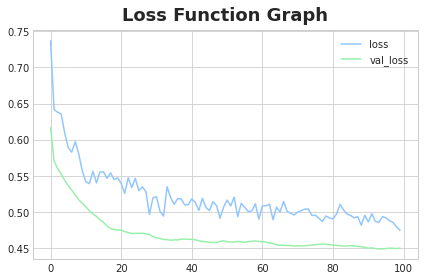

In [349]:
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot().set_title('Loss Function Graph', fontsize=18)

In [350]:
y_pred_dnn2 = model2.predict(X_val_noLAT)
y_pred_dnn2 = pd.DataFrame(y_pred_dnn2)

y_val_dnn2 = pd.DataFrame(y_val).reset_index(drop=True)

for i in range(len(y_pred_dnn2)):
  if (y_pred_dnn2.iloc[i][0] > 0.5):
    y_pred_dnn2.iloc[i][0] = 1
  else:
    y_pred_dnn2.iloc[i][0] = 0

              precision    recall  f1-score   support

           0     0.9375    0.4167    0.5769        36
           1     0.8037    0.9885    0.8866        87

    accuracy                         0.8211       123
   macro avg     0.8706    0.7026    0.7318       123
weighted avg     0.8429    0.8211    0.7960       123

Total false count: 22 
Accuracy: 82.11%


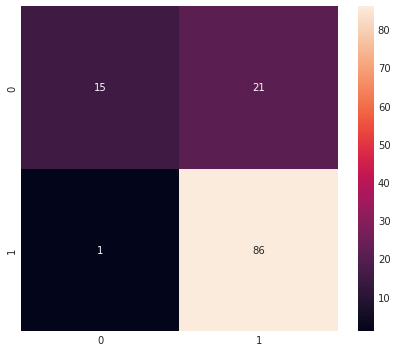

In [351]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val_dnn2.values,y_pred_dnn2), annot=True, fmt=".0f")
print(classification_report(y_val_dnn2.values,y_pred_dnn2, digits=4))
false=[]
  
for i in range(len(y_val_dnn2.values)):
      if y_val_dnn2.values[i]!=y_pred_dnn2.iloc[i][0]:
          false.append(i)
          
print("Total false count: %d "%len(false))  
print("Accuracy: %0.2f%%"%(accuracy_score(y_val_dnn2.values, y_pred_dnn2) * 100))

## Summary
1. Based on Exploratory Data Analysis:
    - Most of the clients are male, married, or graduated.
    - Most of the clients are employee.
    - Clients tend to have one-year loan amount term.
    - Most of the clients came from semiurban area, followed by urban area and rural area.
    - Most of the clients have low income.
    - 'Credit_History' has the strongest correlation with target variable (Loan_Status). It means that this variable will affect the target variable more compared to other variables.
2. Based on Model Prediction Performance:
    - Using XGBoost: 79.67%
    - Using XGBoost (BoostARootA Selected Features): 79.67%
    - Using SVM Classifier: 82.11%
    - Using Logistic Regression: 82.11%
    - Using LGBM Tuner: 81.30%
    - Using Deep Neural Network: 82.11%
    - Using Deep Neural Network (Pearson Corr. Selected Features): 82.11%
    - There is almost no significant difference on XGBoost accuracy before and after BoostARootA feature selection applied. This may happens due to the amount of data. This condition also applies on SVM Classifier, Logistic Regression, also DNN as well.
    - There is a difference between the model trained on DNN with selected features from LGBM Tuner and without them. The main difference is that the trained model with selected features reach the minimum convergence faster than the trained model with only BoostARootA feature selection.